# Random Forest Rangers - Predicting Car Sales Prices
## Preprocessing

In [213]:
# Install dependencies
!pip install -q -r requirements.txt

In [214]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [215]:
dataset = pd.read_csv('./data/used_car_prices_original.csv')
print(dataset.dtypes)

brand           object
model           object
model_year       int64
milage          object
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price           object
dtype: object


### Ensure consistent data formatting

In [216]:
dataset = dataset.copy()

# Function to reformat numeric attributes with non-numeric elements such as currency symbols
def reformat_non_numeric(text):
    if isinstance(text, (float, int)):
        return text
    return float(re.sub(r'[^\d.]', '', text))

# Function to reformat the clean title column
def reformat_clean_title(text):
    return 1 if text == 'Yes' else 0

# Function to reformat the accident column
def reformat_accident(text):
    return 0 if text == '' or text == 'None reported' else 1

# Reformat the existing columns
dataset['clean_title'] = dataset['clean_title'].apply(reformat_clean_title)
dataset['price'] = dataset['price'].apply(reformat_non_numeric)
dataset['milage'] = dataset['milage'].apply(reformat_non_numeric)
dataset['accident'] = dataset['accident'].apply(reformat_accident)

dataset = dataset.copy()
dataset.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,1,10300.0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,1,38005.0
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,0,54598.0
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,1,15500.0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,0,34999.0


### Extract additional features

In [217]:
dataset = dataset.copy()

# Function to extract number of cylinders
def extract_cylinders(text):
    match = re.search(r'(\d+)\s*Cylinder', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract horsepower
def extract_hp(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*HP', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract cubic capacity
def extract_capacity(text):
    match = re.search(r'(\d+(?:\.\d+)?)\s*L', text, re.IGNORECASE)
    return float(match.group(1)) if match else None

# Function to extract whether the car has a turbo
def extract_turbo(text):
    match = re.search(r'Turbo', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract gear type
def extract_gear_type(text):
    match_automatic = re.search(r'Automatic|A/T', text, re.IGNORECASE)
    match_manual = re.search(r'Manual|M/T', text, re.IGNORECASE)
    return 1 if match_automatic else 0 if match_manual else None

# Function to extract the number of gears
def extract_gears(text):
    match = re.search(r'(\d+)-Speed\b', text, re.IGNORECASE)
    return int(match.group(1)) if match else None

# Function to extract whether the car has dual shift
def extract_dual_shift(text):
    match = re.search(r'Dual Shift', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract whether the car has a monochrome color
monochrome = ['Black', 'White', 'Silver', 'Gray']
def extract_monochrome_color(text):
    for color in monochrome:
        match = re.search(color, text, re.IGNORECASE)
        if match:
            return 1
    return 0

# Function to check if interior and exterior colors match
def extract_color_match(row):
    return 1 if row['ext_col'].lower() == row['int_col'].lower() else 0

# Function to extract if the car is a hybrid
def extract_hybrid(text):   
    match = re.search(r'Hybrid', text, re.IGNORECASE)
    return 1 if match else 0
 
# Function to extract if the car is diesel
def extract_diesel(text):
    match = re.search(r'Diesel', text, re.IGNORECASE)
    return 1 if match else 0
    
# Function to extract if the car is gasolin
def extract_gasoline(text):
    match = re.search(r'Gasoline', text, re.IGNORECASE)
    return 1 if match else 0

# Function to extract mileage per year
def extract_mileage_per_year(row):
    vehicle_age = 2024 - row['model_year']
    return row['milage'] / max(vehicle_age, 1)

# Apply the extraction functions to create new columns
dataset['cylinders'] = dataset['engine'].astype(str).apply(extract_cylinders)
dataset['horsepower'] = dataset['engine'].astype(str).apply(extract_hp)
dataset['cubic_capacity'] = dataset['engine'].astype(str).apply(extract_capacity)
dataset['turbo'] = dataset['engine'].astype(str).apply(extract_turbo)
dataset['is_automatic'] = dataset['transmission'].astype(str).apply(extract_gear_type)
dataset['gears'] = dataset['transmission'].astype(str).apply(extract_gears)
dataset['dual_shift'] = dataset['transmission'].astype(str).apply(extract_dual_shift)
dataset['ext_col_mon'] = dataset['ext_col'].astype(str).apply(extract_monochrome_color)
dataset['int_col_mon'] = dataset['int_col'].astype(str).apply(extract_monochrome_color)
dataset['color_match'] = dataset.apply(lambda row: extract_color_match(row), axis=1)
dataset['is_hybrid'] = dataset['fuel_type'].astype(str).apply(extract_hybrid)
dataset['is_diesel'] = dataset['fuel_type'].astype(str).apply(extract_diesel)
dataset['is_gasoline'] = dataset['fuel_type'].astype(str).apply(extract_gasoline)
#dataset['mileage_per_year'] = dataset.apply(lambda row: extract_mileage_per_year(row), axis=1)

dataset = dataset.copy()
dataset.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,turbo,is_automatic,gears,dual_shift,ext_col_mon,int_col_mon,color_match,is_hybrid,is_diesel,is_gasoline
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,...,0,1.0,6.0,0,1,1,1,0,0,0
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,...,0,1.0,8.0,0,0,1,0,0,0,1
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,...,0,1.0,NaN,0,0,1,0,0,0,1
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,...,0,1.0,7.0,0,1,1,1,1,0,0
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,...,1,1.0,8.0,0,1,1,0,0,0,1


### Encode categorical features

In [218]:
# Calculate the average sales price for each brand
brand_avg_price = dataset.groupby('brand')['price'].mean()

# Divide the brands into three quantiles based on their average sales price
nQuantiles = 6
quantiles = pd.qcut(brand_avg_price, nQuantiles, labels=np.arange(1, nQuantiles+1))

# Create a dictionary to map each brand to its quantile value
brand_to_quantile = quantiles.to_dict()

# Encode the brand feature in the dataset
dataset['brand_encoded'] = dataset['brand'].map(brand_to_quantile)

dataset.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,...,is_automatic,gears,dual_shift,ext_col_mon,int_col_mon,color_match,is_hybrid,is_diesel,is_gasoline,brand_encoded
0,Ford,Utility Police Interceptor Base,2013,51000.0,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,1,...,1.0,6.0,0,1,1,1,0,0,0,4
1,Hyundai,Palisade SEL,2021,34742.0,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,1,...,1.0,8.0,0,0,1,0,0,0,1,2
2,Lexus,RX 350 RX 350,2022,22372.0,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,0,...,1.0,NaN,0,0,1,0,0,0,1,4
3,INFINITI,Q50 Hybrid Sport,2015,88900.0,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,0,...,1.0,7.0,0,1,1,1,1,0,0,2
4,Audi,Q3 45 S line Premium Plus,2021,9835.0,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,0,...,1.0,8.0,0,1,1,0,0,0,1,4


### Compute pairwise correlations

<Axes: >

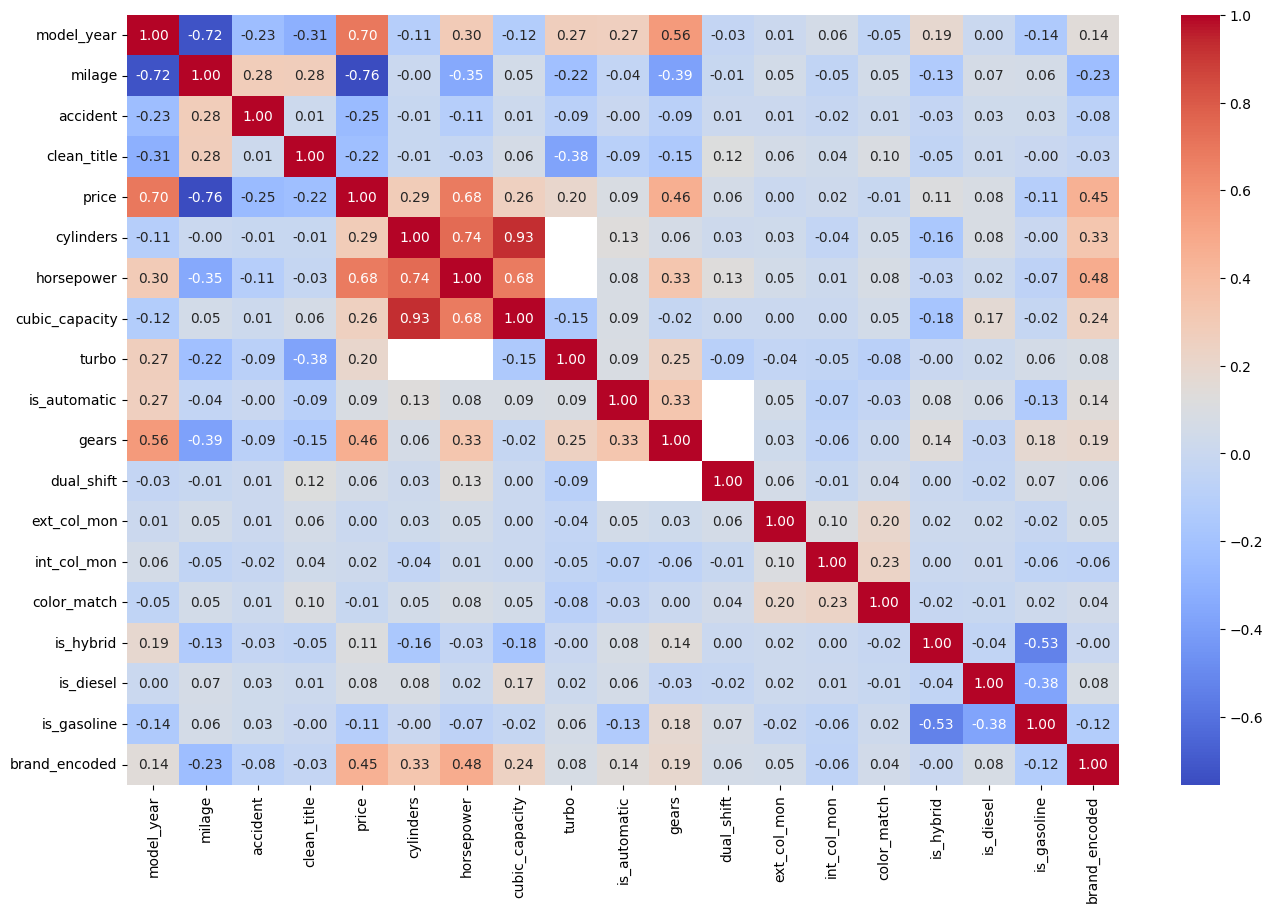

In [219]:
# Select only numeric columns
non_numeric_columns = dataset.select_dtypes(exclude=[np.number]).columns

# Drop non-numeric columns
dataset = dataset.drop(columns=non_numeric_columns)

# Calculate the Spearman correlation matrix
spearman_corr = dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

High correlations between:
- `Model Year` and `Mileage`
- `Cylinders`, `Cubic Capacity` and `Horsepower`

### Handle highly correlated features

Correlation between `cubic_capacity`, `horsepower` and `cylinders`.

In [220]:
# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
available_horsepower = dataset['horsepower'].notnull()
available_cubic_capacity = dataset['cubic_capacity'].notnull()
available_cylinders = dataset['cylinders'].notnull()

# Calculate the number of rows with available values
all_available = available_horsepower & available_cubic_capacity & available_cylinders
two_available = (available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                (available_horsepower & ~available_cubic_capacity & available_cylinders) | \
                (~available_horsepower & available_cubic_capacity & available_cylinders)
one_available = (available_horsepower & ~available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & available_cubic_capacity & ~available_cylinders) | \
                        (~available_horsepower & ~available_cubic_capacity & available_cylinders)
none_available = ~(available_horsepower | available_cubic_capacity | available_cylinders)

# Calculate the number of rows with available values for horsepower, cubic_capacity, and cylinders
sum_all_available = all_available.sum()
sum_two_available = two_available.sum()
sum_one_available = one_available.sum()
sum_none_available = none_available.sum()

# Calculate the percentage of rows with available values for horsepower, cubic_capacity, and cylinders
percentage_all_available = sum_all_available / len(dataset) * 100
percentage_two_available = sum_two_available / len(dataset) * 100
percentage_one_available = sum_one_available / len(dataset) * 100
percentage_none_available = sum_none_available / len(dataset) * 100

print(f"Rows with all available values: {sum_all_available} ({percentage_all_available:.2f}%)")
print(f"Rows with two available values: {sum_two_available} ({percentage_two_available:.2f}%)")
print(f"Rows with one available value: {sum_one_available} ({percentage_one_available:.2f}%)")
print(f"Rows with no available values: {sum_none_available} ({percentage_none_available:.2f}%)")
print(f"Rows with at least one available value: {sum_all_available + sum_two_available + sum_one_available} ({percentage_all_available + percentage_two_available + percentage_one_available:.2f}%)")

Rows with all available values: 3057 (76.25%)
Rows with two available values: 18 (0.45%)
Rows with one available value: 850 (21.20%)
Rows with no available values: 84 (2.10%)
Rows with at least one available value: 3925 (97.90%)


In [221]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, StandardScaler, RobustScaler

# Step 1: Impute missing values
imputer = KNNImputer(n_neighbors=3)
dataset[['horsepower', 'cubic_capacity', 'cylinders']] = imputer.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

# Step 2: Normalize the features
scaler = RobustScaler()
dataset[['horsepower', 'cubic_capacity', 'cylinders']] = scaler.fit_transform(dataset[['horsepower', 'cubic_capacity', 'cylinders']])

# Step 3: Calculate the synthetic variable
dataset['engine_score'] = dataset[['horsepower', 'cubic_capacity', 'cylinders']].mean(axis=1)
dataset.loc[dataset[['horsepower', 'cubic_capacity', 'cylinders']].isnull().all(axis=1), 'engine_score'] = 0

### Correlation matrix heatmap

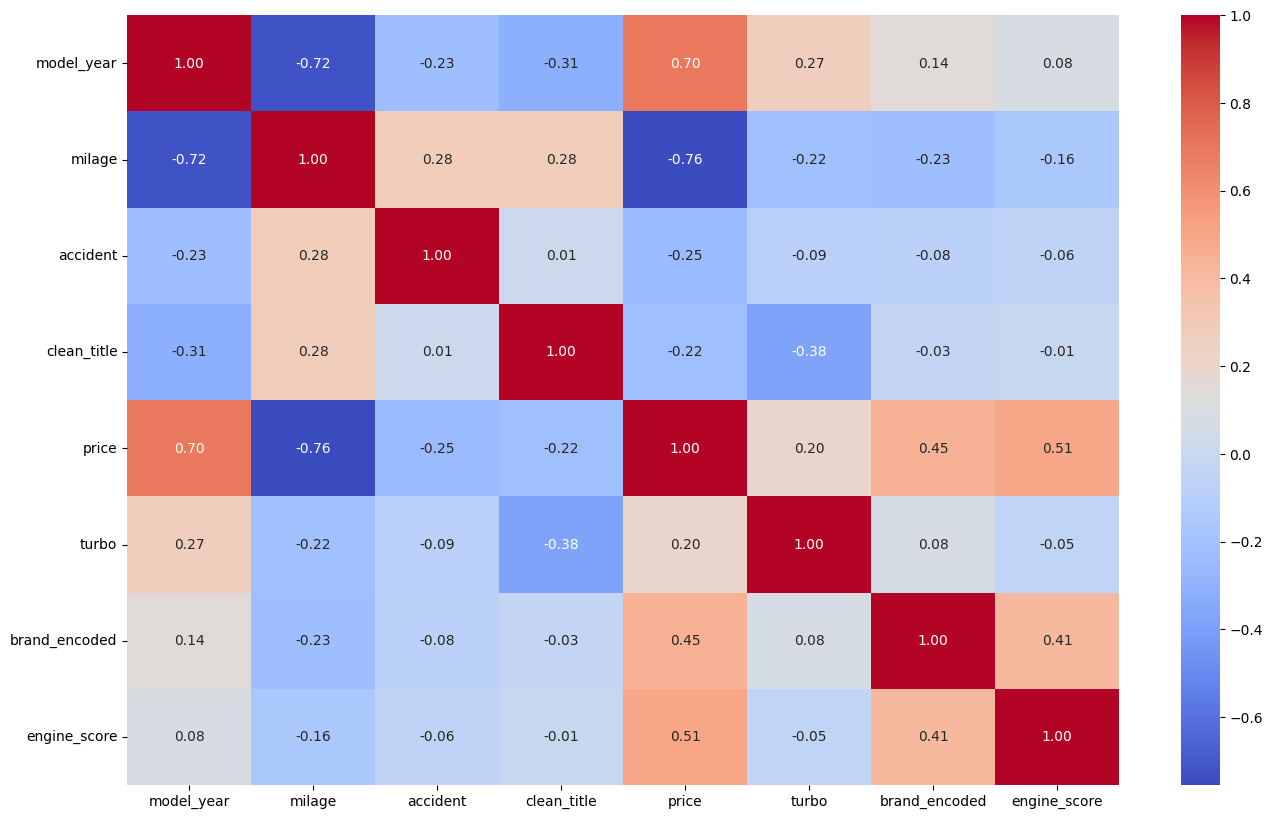

In [222]:
# Calculate the Spearman correlation
spearman_corr = dataset.corr(method='spearman')

# Filter the dataset to keep only the high correlation features
high_corr_features = spearman_corr[abs(spearman_corr['price']) >= 0.2].index
filtered_dataset = dataset[high_corr_features]

# Filter out highly correlated features
filtered_dataset = filtered_dataset.drop(['cylinders', 'horsepower', 'cubic_capacity'], axis=1)

# Filter out features with high percentage of missing values
filtered_dataset = filtered_dataset.drop(['gears'], axis=1)

# Calculate the Spearman correlation matrix
spearman_corr = filtered_dataset.corr(method='spearman')

# Plot the correlation matrix
plt.figure(figsize=(16, 10))
sns.heatmap(spearman_corr, annot=True, fmt=".2f", cmap='coolwarm')

dataset = filtered_dataset.copy()

### Persist preprocessed data

In [223]:
# Save the preprocessed dataset
dataset.to_csv('./data/used_car_prices_preprocessed.csv', index=False)